# Import

In [1]:
# ======================================================
# 주가 데이터 
import FinanceDataReader as fdr
import pandas_datareader.data as pdr

# ======================================================
# TA-Lib
# import talib

# ======================================================
# basic library
import warnings

import openpyxl
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import time
import math
import os
import os.path
import random
import shutil
import glob

# ======================================================
# tqdm
from tqdm import tqdm

# ======================================================
# datetime
from datetime import timedelta, datetime

# ======================================================
# plotting library
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.subplots as ms
import plotly.express as px

import mplfinance as fplt
from mplfinance.original_flavor import candlestick2_ohlc, volume_overlay

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.dates import MonthLocator
from PIL import Image

import seaborn as sns
import cv2
import csv

# plt.rcParams['figure.dpi'] = 150
from IPython.display import clear_output

# 예시로 확인해보기

In [39]:
with open('./img_without_vol_10/train_moving/000660_moving_label.txt', 'r') as f:
    lines = f.readlines()

labels = {}

for line in lines:
    path, direction = line.strip().split(',')
    label = path.split('/')[-1]
    if direction == 'Up':
        labels[label] = 1
    elif direction == 'Down':
        labels[label] = 0

In [40]:
test_dir = './img_without_vol_10/test/000660/'
results = []
for folder_name in os.listdir(test_dir):
    folder_path = os.path.join(test_dir, folder_name)
    if os.path.isdir(folder_path):
        up_count = 0
        down_count = 0
        for image_file in os.listdir(folder_path):
            if image_file.endswith('.png'):
                image_name = image_file.split('.')[0]
                if image_name in labels:
                    if labels[image_name] == 1:
                        up_count += 1
                    elif labels[image_name] == 0:
                        down_count += 1
        results.append((folder_name, up_count, down_count))

train_df = pd.DataFrame(results, columns=['stock_frame', 'Up', 'Down'])

# stock_frame 열에서 '_뒤'의 숫자 값을 추출하여 정수형으로 저장
train_df['num'] = train_df['stock_frame'].str.split('_').str.get(1).astype(int)

# '_뒤'의 숫자 값을 기준으로 오름차순 정렬
train_df = train_df.sort_values(by='num')

# 정렬 후 필요 없어진 열 삭제
train_df = train_df.drop('num', axis=1).reset_index().drop('index', axis=1)

train_df.head()

,stock_frame,Up,Down
0,000660_0,10,5
1,000660_5,7,8
2,000660_10,10,5
3,000660_15,8,7
4,000660_20,8,7


In [41]:
train_df['position'] = ''

for i in range(len(train_df)):
    if train_df['Up'][i] >= 8:
        train_df['position'][i] = 1
        
    elif train_df['Down'][i] >= 8:
        train_df['position'][i] = 0
        
    else:
        train_df['position'][i] = None

c:\Users\coden\anaconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
c:\Users\coden\anaconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\coden\anaconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_

In [42]:
train_df

,stock_frame,Up,Down,position
0,000660_0,10,5,1
1,000660_5,7,8,0
2,000660_10,10,5,1
3,000660_15,8,7,1
4,000660_20,8,7,1
...,...,...,...,...
92,000660_460,5,10,0
93,000660_465,7,8,0
94,000660_470,5,10,0
95,000660_475,8,7,1


In [43]:
# 파일 경로와 이름
filename = './img_without_vol_10/test_moving/000660_moving_label.txt'

# 파일 열기
with open(filename, 'r') as f:
    file_list = f.read().splitlines()

# 데이터프레임으로 변환
test_df = pd.DataFrame([x.split(',') for x in file_list], columns=['filename', 'direction'])
test_df['stock_frame'] = test_df['filename'].str.split('/').str[4]
test_df['stock_frame'] = test_df['stock_frame'].str.replace('_moving', '')
test_df.drop(columns=['filename'], inplace=True)

In [44]:
test_df['real_position'] = ''
for i in range(len(test_df)):
    if test_df['direction'][i] == "Up":
        test_df['real_position'][i] = 1
    else:
        test_df['real_position'][i] = 0

In [45]:
test_df[['stock_frame', 'real_position']]

,stock_frame,real_position
0,000660_0,0
1,000660_5,0
2,000660_10,0
3,000660_15,1
4,000660_20,1
...,...,...
92,000660_460,0
93,000660_465,0
94,000660_470,0
95,000660_475,0


In [46]:
final_df = pd.merge(train_df[['stock_frame', 'position']], test_df[['stock_frame', 'real_position']], on = 'stock_frame', how = 'inner')

In [47]:
# None 값이 있는 행 제거
final_df.dropna(inplace=True)

In [48]:
accuracy = (final_df['position'] == final_df['real_position']).mean()

In [49]:
print(f'정확도: {accuracy:.2%}')

정확도: 44.79%


# 매매 백테스팅 준비

In [67]:
test_start_day = '2021-01-01'
test_end_day = '2022-12-31'

In [68]:
stock_data = pd.DataFrame(fdr.DataReader('000660', test_start_day, test_end_day))
stock_data = stock_data[['Open', 'High', 'Low', 'Close', 'Volume']].astype(float)
stock_data = stock_data.reset_index()

In [69]:
# '매매 신호' 데이터 프레임에서 position 열의 값을 추출합니다.
positions = list(train_df['position'])

# 삼성전자 데이터 프레임의 10번째 행부터 5행 단위로 position 열 값을 채웁니다.
for i in range(10, len(stock_data), 5):
    stock_data.loc[i, 'position'] = positions[(i-10)//5]
    
# stock_data['position'] = stock_data['position'].astype(int)

In [70]:
stock_data = stock_data.dropna(subset=['position']).reset_index(drop=True)

In [71]:
stock_data['position'] = stock_data['position'].astype(int)

In [72]:
# Open열의 0값을 해당 행의 Close열 값으로 대체
stock_data.loc[stock_data['Open'] == 0, 'Open'] = stock_data['Close']

In [73]:
stock_data

,Date,Open,High,Low,Close,Volume,position
0,2021-01-18,126000.0,131000.0,125000.0,130000.0,5927419.0,1
1,2021-01-25,130000.0,135000.0,129500.0,135000.0,5061864.0,0
2,2021-02-01,121000.0,126000.0,118000.0,125000.0,5620305.0,1
3,2021-02-08,127500.0,128000.0,125000.0,125000.0,2876471.0,1
4,2021-02-17,131000.0,131000.0,128000.0,130000.0,3621178.0,1
...,...,...,...,...,...,...,...
91,2022-11-28,84100.0,84200.0,82900.0,83100.0,2471506.0,0
92,2022-12-05,81900.0,82300.0,80700.0,81000.0,3516456.0,0
93,2022-12-12,80100.0,81300.0,79500.0,81100.0,1242007.0,0
94,2022-12-19,78300.0,80100.0,78300.0,79000.0,1813544.0,1


# 매매 백테스팅 용 매매 신호 입력하기

In [74]:
# 시작 전 기본설정된 매매 신호는 'No action'이라고 가정합니다.
action = "No action"

# position 값을 사용해 action 값을 설정하고 컬럼으로 추가합니다.
for i in range(len(stock_data)):
    # 이전 행의 position 값
    if i == 0:
        prev_pos = 0  # 첫 번째 행에서는 이전 행이 없으므로 0으로 설정합니다.
    else:
        prev_pos = stock_data.loc[i-1, 'position']
    # 현재 행의 position 값
    curr_pos = stock_data.loc[i, 'position']
    
    # 첫 번째 행에서 position 값에 따라 action 값을 결정합니다.
    if i == 0:
        if curr_pos == 0:
            action = "No action"
        else:
            action = "매수"
    # 이전 행에서 매수한 경우
    elif prev_pos == 1:
        # 현재 행에서도 매수를 유지하는 경우
        if curr_pos == 1:
            action = "홀딩"
        # 현재 행에서 매도를 하는 경우
        else:
            action = "매도"
    # 이전 행에서 매도를 한 경우 또는 'No action'을 한 경우
    else:
        # 현재 행에서 매도를 한 경우 또는 'No action'을 한 경우
        if curr_pos == 0:
            action = "No action"
        # 현재 행에서 매수를 하는 경우
        else:
            action = "매수"
    
    if i == len(stock_data) - 1:
        action = "매도"
    # action 값을 컬럼으로 추가합니다.
    stock_data.loc[i, 'action'] = action

In [75]:
stock_data

,Date,Open,High,Low,Close,Volume,position,action
0,2021-01-18,126000.0,131000.0,125000.0,130000.0,5927419.0,1,매수
1,2021-01-25,130000.0,135000.0,129500.0,135000.0,5061864.0,0,매도
2,2021-02-01,121000.0,126000.0,118000.0,125000.0,5620305.0,1,매수
3,2021-02-08,127500.0,128000.0,125000.0,125000.0,2876471.0,1,홀딩
4,2021-02-17,131000.0,131000.0,128000.0,130000.0,3621178.0,1,홀딩
...,...,...,...,...,...,...,...,...
91,2022-11-28,84100.0,84200.0,82900.0,83100.0,2471506.0,0,No action
92,2022-12-05,81900.0,82300.0,80700.0,81000.0,3516456.0,0,No action
93,2022-12-12,80100.0,81300.0,79500.0,81100.0,1242007.0,0,No action
94,2022-12-19,78300.0,80100.0,78300.0,79000.0,1813544.0,1,매수


In [76]:
df_buy_sell = stock_data[stock_data['action'].isin(['매수', '매도'])].reset_index(drop=True)

In [77]:
df_buy_sell.head()

,Date,Open,High,Low,Close,Volume,position,action
0,2021-01-18,126000.0,131000.0,125000.0,130000.0,5927419.0,1,매수
1,2021-01-25,130000.0,135000.0,129500.0,135000.0,5061864.0,0,매도
2,2021-02-01,121000.0,126000.0,118000.0,125000.0,5620305.0,1,매수
3,2021-04-15,136000.0,139000.0,136000.0,137500.0,2291160.0,0,매도
4,2021-04-22,134500.0,135500.0,133000.0,133000.0,3007457.0,1,매수


# 수익률 비교

In [78]:
# 첫 행과 마지막 행의 Open과 Close 값을 가져옴
start_price = stock_data.loc[0, 'Open']
end_price = stock_data.loc[len(stock_data) - 1, 'Close']

# 수익률 계산
profit_rate = (end_price - start_price) / start_price * 100

# 결과를 데이터 프레임으로 만듦
result = pd.DataFrame({'Start Price': [start_price], 'End Price': [end_price], 'Profit Rate(%)': [profit_rate]})

In [79]:
result

,Start Price,End Price,Profit Rate(%)
0,126000.0,77000.0,-38.888889


In [80]:
buy_dates = []
buy_prices = []

# 누적 수익률을 계산할 변수 초기화
total_return = 1

# 데이터 프레임에 누적 수익률 컬럼 추가
df_buy_sell['Accumulated Return'] = None

# 첫 행부터 끝까지 반복
for i in range(len(df_buy_sell)):

    # 현재 행의 action이 매수인 경우
    if df_buy_sell.loc[i, 'action'] == '매수':
        
        # 매수한 날짜와 가격을 리스트에 추가
        buy_dates.append(df_buy_sell.loc[i, 'Date'])
        buy_prices.append(df_buy_sell.loc[i, 'Open'])
        
    # 현재 행의 action이 매도인 경우
    elif df_buy_sell.loc[i, 'action'] == '매도':
        
        # 이전에 매수한 가격이 없다면 continue
        if len(buy_prices) == 0:
            continue
        
        # 이전에 매수한 가격이 있다면 가장 최근의 가격으로 매도
        sell_price = df_buy_sell.loc[i, 'Close']
        buy_price = buy_prices.pop()
        
        # 수익률 계산 및 누적 수익률에 반영
        return_rate = sell_price / buy_price
        total_return *= return_rate
        
        # 누적 수익률을 데이터프레임에 반영
        df_buy_sell.loc[i, 'Accumulated Return'] = round((total_return - 1) * 100, 2)

# 누적 수익률 출력
print('누적 수익률:', round((total_return - 1) * 100, 2), '%')

누적 수익률: -39.88 %


In [81]:
buy_dates = []
buy_prices = []
return_rates = []  # 각 매도 별 수익률 저장 리스트

# 누적 수익률을 계산할 변수 초기화
total_return = 1

# 데이터 프레임에 누적 수익률, 매수 가격, 매도 가격, 실현 수익 컬럼 추가
df_buy_sell['Accumulated Return'] = None
df_buy_sell['Return Rate'] = None
df_buy_sell['Buy Price'] = None
df_buy_sell['Sell Price'] = None
df_buy_sell['Realized Return'] = None

# 첫 행부터 끝까지 반복
for i in range(len(df_buy_sell)):

    # 현재 행의 action이 매수인 경우
    if df_buy_sell.loc[i, 'action'] == '매수':
        
        # 매수한 날짜와 가격을 리스트에 추가
        buy_dates.append(df_buy_sell.loc[i, 'Date'])
        buy_prices.append(df_buy_sell.loc[i, 'Open'])
        
    # 현재 행의 action이 매도인 경우
    elif df_buy_sell.loc[i, 'action'] == '매도':
        
        # 이전에 매수한 가격이 없다면 continue
        if len(buy_prices) == 0:
            continue
        
        # 이전에 매수한 가격이 있다면 가장 최근의 가격으로 매도
        sell_price = df_buy_sell.loc[i, 'Close']
        buy_price = buy_prices.pop()
        
        # 수익률 계산 및 누적 수익률에 반영
        return_rate = sell_price / buy_price
        total_return *= return_rate
        
        # 누적 수익률, 매수 가격, 매도 가격, 실현 수익을 데이터프레임에 반영
        df_buy_sell.loc[i, 'Accumulated Return'] = round((total_return - 1) * 100, 2)
        df_buy_sell.loc[i, 'Return Rate'] = round((return_rate - 1) * 100, 2)
        df_buy_sell.loc[i, 'Buy Price'] = buy_price
        df_buy_sell.loc[i, 'Sell Price'] = sell_price
        df_buy_sell.loc[i, 'Realized Return'] = sell_price - buy_price
        return_rates.append(round((return_rate - 1) * 100, 2))

# 누적 수익률과 각 매도 별 수익률 출력
print('누적 수익률:', round((total_return - 1) * 100, 2), '%')
print('각 매도 별 수익률:', return_rates)

누적 수익률: -39.88 %
각 매도 별 수익률: [7.14, 13.64, -3.35, -6.64, -3.94, -6.98, -1.68, -10.57, 1.91, -5.21, 6.54, 3.32, -8.91, -9.23, -8.87, -3.56, -2.28, -5.5, 7.09, -0.99, -0.93, -0.96, 0.11, 6.25, -10.3, -1.66]


In [82]:
df_buy_sell = df_buy_sell.dropna(axis = 0)

In [84]:
df_buy_sell.head()

,Date,Open,High,Low,Close,Volume,position,action,Accumulated Return,Return Rate,Buy Price,Sell Price,Realized Return
1,2021-01-25,130000.0,135000.0,129500.0,135000.0,5061864.0,0,매도,7.14,7.14,126000.0,135000.0,9000.0
3,2021-04-15,136000.0,139000.0,136000.0,137500.0,2291160.0,0,매도,21.75,13.64,121000.0,137500.0,16500.0
5,2021-04-29,132000.0,133000.0,129000.0,130000.0,3738266.0,0,매도,17.68,-3.35,134500.0,130000.0,-4500.0
7,2021-05-24,122000.0,122500.0,119000.0,119500.0,3188734.0,0,매도,9.87,-6.64,128000.0,119500.0,-8500.0
9,2021-06-21,121000.0,123000.0,120500.0,122000.0,3275288.0,0,매도,5.54,-3.94,127000.0,122000.0,-5000.0


# Buy and Hold와 비교하기

In [1387]:
merge_df = pd.merge(stock_data, df_buy_sell[['Date', 'Accumulated Return', 'Return Rate']], on = 'Date', how = 'outer')

In [1289]:
merge_df['Accumulated Return'] = merge_df['Accumulated Return'].replace(0, pd.np.nan).ffill().fillna(0)

c:\Users\coden\anaconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """Entry point for launching an IPython kernel.


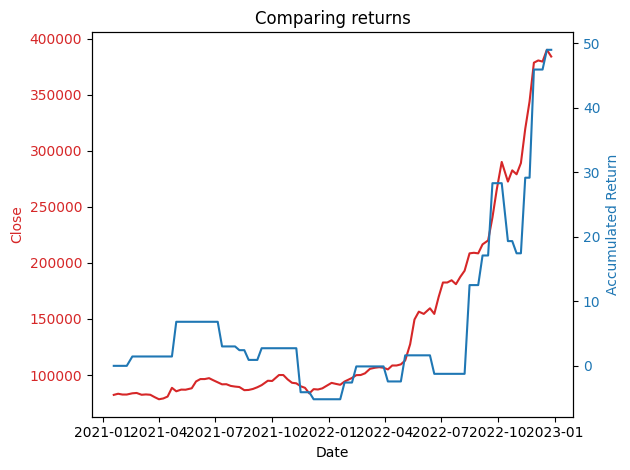

In [517]:
# x축으로 사용할 날짜 데이터
dates = merge_df['Date']

# y축으로 사용할 데이터
close_prices = merge_df['Close']
acc_return = merge_df['Accumulated Return']

# 그래프 생성
fig, ax1 = plt.subplots()

# Close 데이터 시각화
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Close', color=color)
ax1.plot(dates, close_prices, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Accumulated Return 데이터 시각화
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accumulated Return', color=color)
ax2.plot(dates, acc_return, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# 그래프 출력
plt.title('Comparing returns')
fig.tight_layout()
plt.show()

# MDD 계산하기

In [1429]:
def calculate_mdd(dataframe):
    """
    :param dataframe: pandas.DataFrame, stock price data containing columns 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'position', and 'action'
    :return: float, maximum drawdown of the investment
    """

    dataframe = dataframe[['Date', 'Close', 'position']]
    dataframe = dataframe.set_index('Date')
    
    # Daily log returns
    dataframe['returns'] = np.log(dataframe['Close'] / dataframe['Close'].shift(1))
    
    # Cumulative returns
    dataframe['cumulative_returns'] = np.exp(dataframe['returns'].cumsum()) - 1
    
    # High water mark
    dataframe['high_water_mark'] = dataframe['cumulative_returns'].cummax()
    
    # Drawdown
    dataframe['drawdown'] = dataframe['cumulative_returns'] - dataframe['high_water_mark']
    
    # Maximum Drawdown
    mdd = dataframe['drawdown'].min()
    
    return mdd * 100

In [1430]:
stock_data = pd.DataFrame(fdr.DataReader('004690', test_start_day, test_end_day))
stock_data = stock_data[['Open', 'High', 'Low', 'Close', 'Volume']].astype(float)
stock_data = stock_data.reset_index()

In [1431]:
merge_df = pd.merge(stock_data, df_buy_sell[['Date', 'position']], on = 'Date', how = 'outer')

In [1432]:
calculate_mdd(merge_df)

-27.91262135922321